In [ ]:
## Comparison: batch size 32 (dropout rate = 0.3 as original code)
## Grad-Cam included
## 1) without attention layer
## 2) with attention layer
## 3) without attention layer, without class-weighted loss (just like the original code but with increased batch size from 16)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-28 01:28:39.897094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745818119.916887    7090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745818119.922769    7090 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745818119.938286    7090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745818119.938316    7090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745818119.938319    7090 computation_placer.cc:177] computation placer alr

In [2]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

## Resolution: 64x64

### ResNet50_64

In [3]:
# 1. Load dataset
data_64 = np.load("bloodmnist_64.npz")

# 2. Extract images and labels
train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"].flatten()

val_images_64 = data_64["val_images"]
val_labels_64 = data_64["val_labels"].flatten()

test_images_64 = data_64["test_images"]
test_labels_64 = data_64["test_labels"].flatten()

In [4]:
data_64.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [5]:
# 3. One-hot encode labels
train_labels_cat_64 = to_categorical(train_labels_64, num_classes=8)
val_labels_cat_64 = to_categorical(val_labels_64, num_classes=8)
test_labels_cat_64 = to_categorical(test_labels_64, num_classes=8)

In [6]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator_64 = train_datagen.flow(
    train_images_64, 
    train_labels_cat_64,   
    batch_size=batch_size
)
val_generator_64 = test_datagen.flow(
    val_images_64,
    val_labels_cat_64,
    batch_size=batch_size
)
test_generator_64 = test_datagen.flow(
    test_images_64,
    test_labels_cat_64,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
## WITHOUT ATTENTION

In [8]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

# not applying attention layer for this comparison
# x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
# attention = layers.Attention()([x_reshape, x_reshape])
# attention_output = layers.Reshape(x.shape[1:])(attention)

# x = layers.Multiply()([x, attention_output]) # apply attention layer

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.3)(x) 

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

2025-04-27 21:37:59.664973: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# 6. Compile model 
print("Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3")

# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 581s 1s/step - accuracy: 0.7301 - auc: 0.9275 - loss: 0.8810 - val_accuracy: 0.1472 - val_auc: 0.4675 - val_loss: 11.6626
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.9426 - auc: 0.9952 - loss: 0.1758 - val_accuracy: 0.1396 - val_auc: 0.5656 - val_loss: 4.3152
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.9618 - auc: 0.9970 - loss: 0.1224 - val_accuracy: 0.8984 - val_auc: 0.9910 - val_loss: 0.2929
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 551s 1s/step - accuracy: 0.9654 - auc: 0.9984 - loss: 0.0914 - val_accuracy: 0.9287 - val_auc: 0.9935 - val_loss: 0.2173
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 551s 1s/step - accuracy: 0.9731 - auc: 0.9986 - loss: 0.0772 - val_accuracy: 0.9393 - val_auc: 0.9953 - val_loss: 0.2035
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.9716 - auc: 0.9986 - loss: 0.0832 - val_accuracy: 0.9673 - val_auc: 0.9975 - val_loss: 0.1115
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 550s

In [10]:
model_50_64.save('model_50_64_batch32_noAttention.h5')
model_50_64.save('model_50_64_batch32_noAttention.keras')

In [11]:
# 8. Evaluate model

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3")

test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pixels:      {test_auc_50_64:.4f}")

Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9639 - auc: 0.9971 - loss: 0.1176
ResNet50 test accuracy for 64 pixels: 0.9649
ResNet50 test AUC for 64 pixels:      0.9958


In [12]:
# 9. Precision, recall, f1-score

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3")

y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step
                      precision    recall  f1-score   support

          neutrophil       0.89      1.00      0.94       244
          eosinophil       0.99      1.00      1.00       624
            basophil       0.98      0.98      0.98       311
          lymphocyte       0.93      0.90      0.91       579
            monocyte       0.99      0.98      0.98       243
immature granulocyte       0.96      0.90      0.93       284
        erythroblast       0.95      0.98      0.97       666
            platelet       1.00      0.98      0.99       470

            accuracy                           0.96      3421
           macro avg       0.96      0.96      0.96      3421
        weighted avg       0.97      0.96      0.96      3421



In [13]:
# 10. Performance per class

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3")

cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

Batch Size Comparison: ResNet50 (64x64), batch size 32, no attention layer, dropout rate 0.3
neutrophil           accuracy: 1.0000
eosinophil           accuracy: 1.0000
basophil             accuracy: 0.9839
lymphocyte           accuracy: 0.8964
monocyte             accuracy: 0.9753
immature granulocyte accuracy: 0.9014
erythroblast         accuracy: 0.9835
platelet             accuracy: 0.9787


Found History outputs in cells: [9]


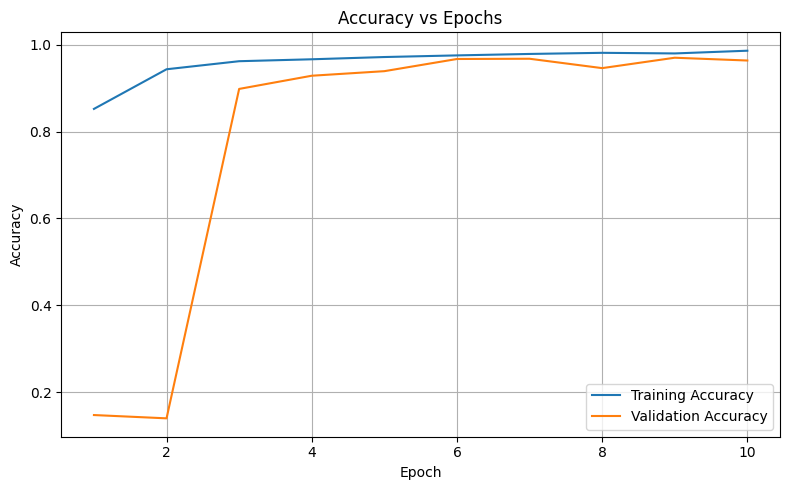

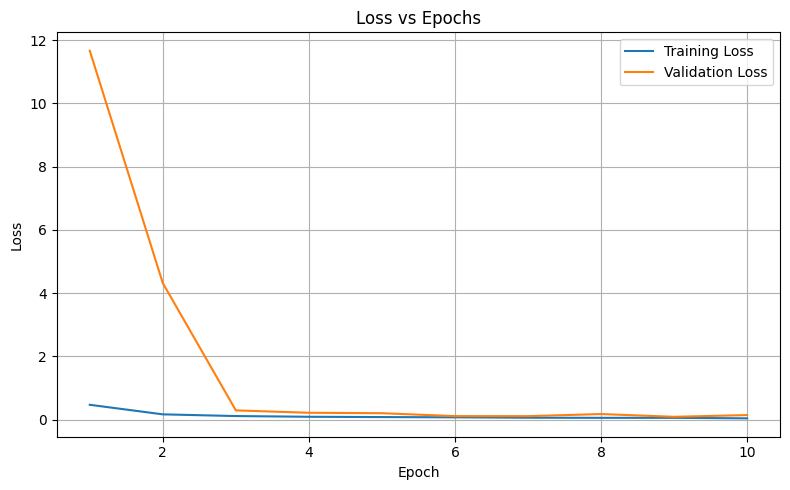

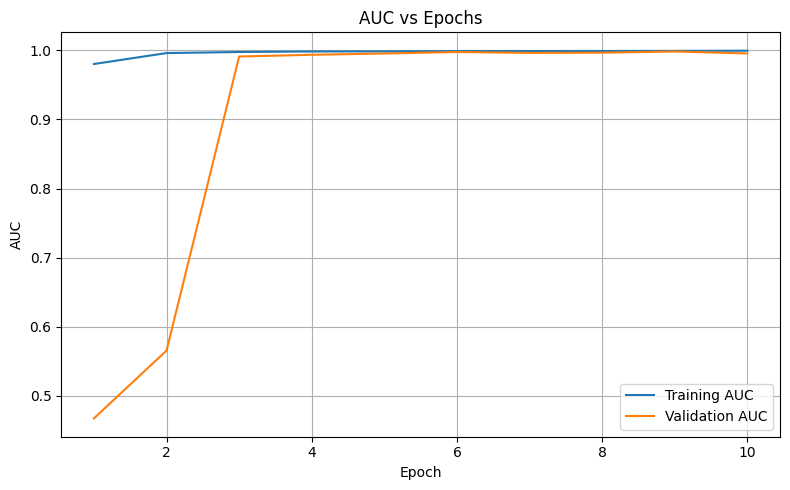

In [15]:
from tensorflow.keras.callbacks import History as HistoryClass

# search for history outputs
ip = get_ipython()
outs = ip.user_ns["Out"]

# all history outputs
history_cells = [num for num, obj in outs.items() if isinstance(obj, HistoryClass)]
print("Found History outputs in cells:", history_cells)

# get most recent history
history = outs[history_cells[-1]]  

epochs = range(1, len(history.history['loss']) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['auc'], label='Training AUC')
plt.plot(epochs, history.history['val_auc'], label='Validation AUC')
plt.title('AUC vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.models import load_model

model_32_attention = load_model('model_50_64_batch32_noAttention.keras')

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 216 variables whereas the saved optimizer has 430 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
## GradCam (batch size 16, original code, dropout rate 0.3)

import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image 

# 1) model details
model = model_32_attention  
img_size = (64, 64)  
preprocess_input = lambda x: x / 255.0  

# 2) 
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 47,155,090 (179.88 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 23,550,986 (89.84 MB)

In [30]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [31]:
# 3) prepare image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image.open(cam_path))

In [ ]:
# path: /shared/home/tzj255/bmi707_fp/image/pixel/image.jpg

# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

!ls ./image/64

In [ ]:
# 6) RUN Grad-CAM on image

Predicted class: 0


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


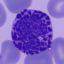

In [32]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/basophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


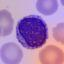

In [33]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/lymphocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 1


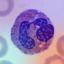

In [34]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/eosinophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


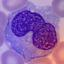

In [35]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/monocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 2


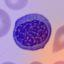

In [36]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/erythroblast_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 6


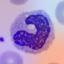

In [37]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/neutrophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


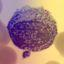

In [38]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/immature_granulocytes_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


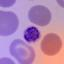

In [27]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/platelet_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

In [ ]:
######################################################################################################

In [ ]:
## WITH ATTENTION

In [8]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output]) # apply attention layer
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x) 

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

2025-04-27 23:26:27.381279: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# 6. Compile model 
print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64_32 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.6323 - auc: 0.8431 - loss: 4.0667 - val_accuracy: 0.1694 - val_auc: 0.5000 - val_loss: 9548.9268
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.9083 - auc: 0.9887 - loss: 0.3040 - val_accuracy: 0.1081 - val_auc: 0.4894 - val_loss: 26.8524
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - accuracy: 0.9348 - auc: 0.9937 - loss: 0.2070 - val_accuracy: 0.8838 - val_auc: 0.9760 - val_loss: 0.6500
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.9396 - auc: 0.9948 - loss: 0.2752 - val_accuracy: 0.9521 - val_auc: 0.9934 - val_loss: 0.9861
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.9543 - auc: 0.9971 - loss: 0.1692 - val_accuracy: 0.9346 - val_auc: 0.9957 - val_loss: 0.1913
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 504s 1s/step - accuracy: 0.9442 - auc: 0.9948 - loss: 0.2197 - val_accuracy: 0.8902 - val_auc: 0.9688 - val_loss: 27.0001
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
model_50_64.save('model_50_64_batch32_Attention.h5')
model_50_64.save('model_50_64_batch32_Attention.keras')

In [11]:
# 8. Evaluate model

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pixels:      {test_auc_50_64:.4f}")

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9552 - auc: 0.9965 - loss: 0.1285 
ResNet50 test accuracy for 64 pixels: 0.9597
ResNet50 test AUC for 64 pixels:      0.9966


In [12]:
# 9. Precision, recall, f1-score

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step
                      precision    recall  f1-score   support

          neutrophil       0.91      1.00      0.95       244
          eosinophil       1.00      0.99      1.00       624
            basophil       0.94      0.98      0.96       311
          lymphocyte       0.90      0.92      0.91       579
            monocyte       0.99      0.91      0.95       243
immature granulocyte       0.98      0.86      0.91       284
        erythroblast       0.96      0.98      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.96      3421
           macro avg       0.96      0.95      0.96      3421
        weighted avg       0.96      0.96      0.96      3421



In [13]:
# 10. Performance per class

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
neutrophil           accuracy: 1.0000
eosinophil           accuracy: 0.9936
basophil             accuracy: 0.9775
lymphocyte           accuracy: 0.9154
monocyte             accuracy: 0.9136
immature granulocyte accuracy: 0.8556
erythroblast         accuracy: 0.9760
platelet             accuracy: 1.0000


Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3


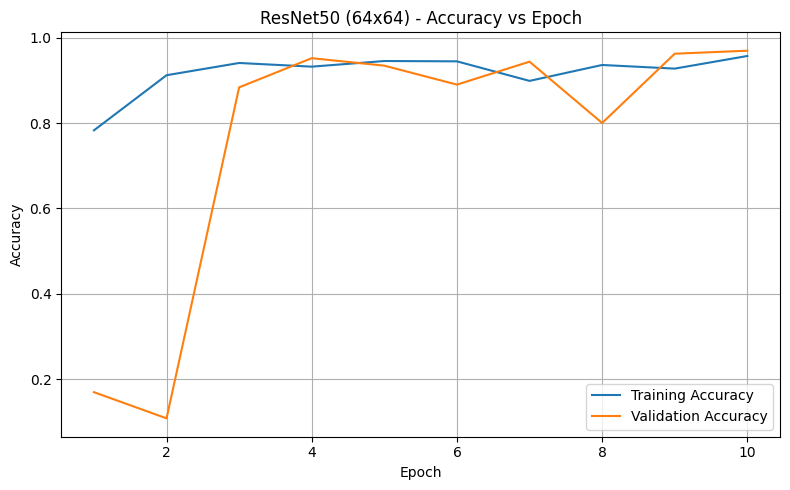

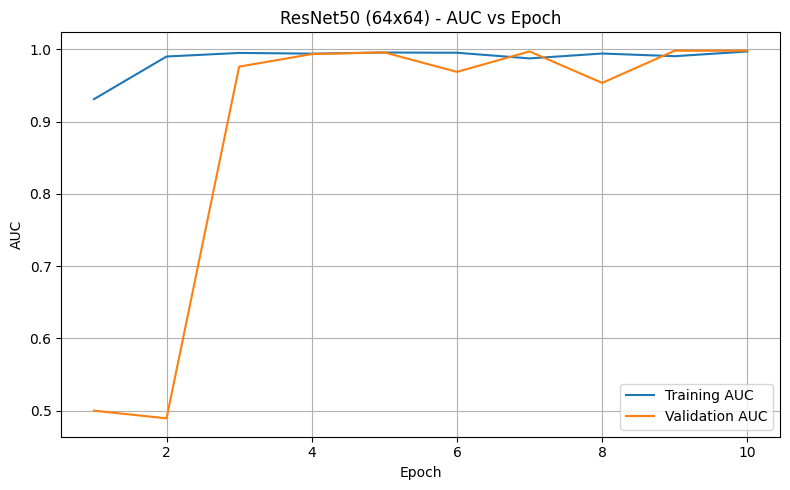

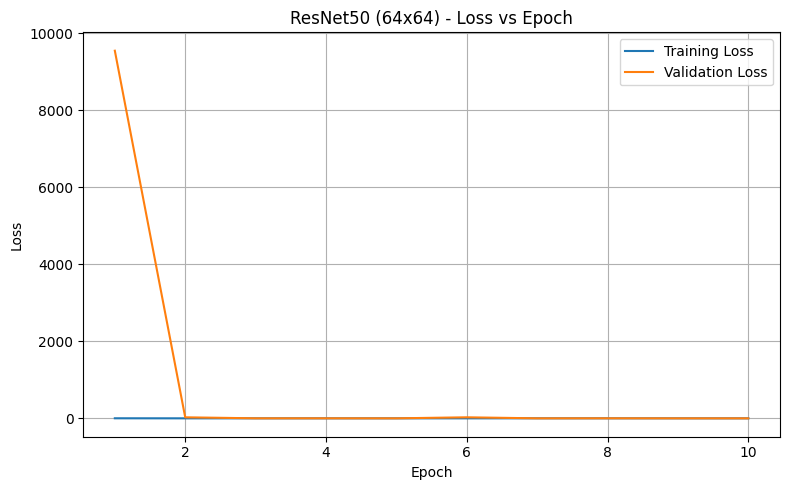

In [14]:
# 11. Plot

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

epochs = range(1, len(history_50_64_32.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64_32.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_64_32.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (64x64) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_64.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64_32.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_64_32.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (64x64) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_64.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64_32.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_64_32.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (64x64) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_64.png")
plt.show()

In [15]:
## GradCam (batch size 16, original code, dropout rate 0.3)

import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image 

# 1) model details
model = model_50_64  
img_size = (64, 64)  
preprocess_input = lambda x: x / 255.0  

# 2) find last conv layer name 
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 70,706,074 (269.72 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,101,970 (179.68 MB)

In [16]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [17]:
# 3) prepare image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image.open(cam_path))

In [ ]:
# path: /shared/home/tzj255/bmi707_fp/image/pixel/image.jpg

# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

!ls ./image/64

In [ ]:
# 6) RUN Grad-CAM on image

Predicted class: 0


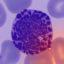

In [20]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/basophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


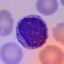

In [21]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/lymphocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 6


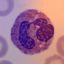

In [22]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/eosinophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


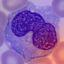

In [23]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/monocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 2


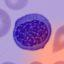

In [24]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/erythroblast_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 6


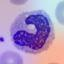

In [25]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/neutrophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


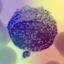

In [26]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/immature_granulocytes_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


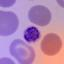

In [27]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/platelet_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

In [ ]:
######################################################################################################

In [ ]:
## NO ATTENTION, NO CLASS WEIGHTED

In [7]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x) 

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

2025-04-28 01:30:13.240702: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# 6. Compile model 
#####SHOULD BE WITHOUT ATTENTION LAYER####
print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

# class-weighted loss
# class_weights = compute_class_weight(class_weight="balanced", 
#                                      classes=np.unique(train_labels_64), y=train_labels_64)
# class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64_32 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64
    # class_weight=class_weight_dict
)

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.7440 - auc: 0.9277 - loss: 0.8237 - val_accuracy: 0.0572 - val_auc: 0.4353 - val_loss: 14.5415
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 524s 1s/step - accuracy: 0.9455 - auc: 0.9952 - loss: 0.1670 - val_accuracy: 0.1414 - val_auc: 0.5168 - val_loss: 15.1394
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9661 - auc: 0.9980 - loss: 0.1010 - val_accuracy: 0.8966 - val_auc: 0.9893 - val_loss: 0.3162
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.9734 - auc: 0.9987 - loss: 0.0797 - val_accuracy: 0.9065 - val_auc: 0.9840 - val_loss: 0.3460
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.9754 - auc: 0.9988 - loss: 0.0732 - val_accuracy: 0.9626 - val_auc: 0.9959 - val_loss: 0.1121
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - accuracy: 0.9793 - auc: 0.9991 - loss: 0.0581 - val_accuracy: 0.9766 - val_auc: 0.9981 - val_loss: 0.0825
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 543

In [9]:
model_50_64.save('model_50_64_batch32_raw.h5')
model_50_64.save('model_50_64_batch32_raw.keras')

In [10]:
# 8. Evaluate model

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

test_loss_50_64, test_acc_50_64, test_auc_50_64 = model_50_64.evaluate(test_generator_64)
print(f"ResNet50 test accuracy for 64 pixels: {test_acc_50_64:.4f}")
print(f"ResNet50 test AUC for 64 pixels:      {test_auc_50_64:.4f}")

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9762 - auc: 0.9989 - loss: 0.0667
ResNet50 test accuracy for 64 pixels: 0.9769
ResNet50 test AUC for 64 pixels:      0.9989


In [11]:
# 9. Precision, recall, f1-score

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step
                      precision    recall  f1-score   support

          neutrophil       0.98      0.99      0.99       244
          eosinophil       1.00      1.00      1.00       624
            basophil       0.96      0.98      0.97       311
          lymphocyte       0.96      0.94      0.95       579
            monocyte       0.98      0.98      0.98       243
immature granulocyte       0.96      0.95      0.96       284
        erythroblast       0.97      0.98      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.98      3421
           macro avg       0.98      0.98      0.98      3421
        weighted avg       0.98      0.98      0.98      3421



In [12]:
# 10. Performance per class

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3
neutrophil           accuracy: 0.9918
eosinophil           accuracy: 0.9984
basophil             accuracy: 0.9839
lymphocyte           accuracy: 0.9361
monocyte             accuracy: 0.9794
immature granulocyte accuracy: 0.9507
erythroblast         accuracy: 0.9790
platelet             accuracy: 0.9979


Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3


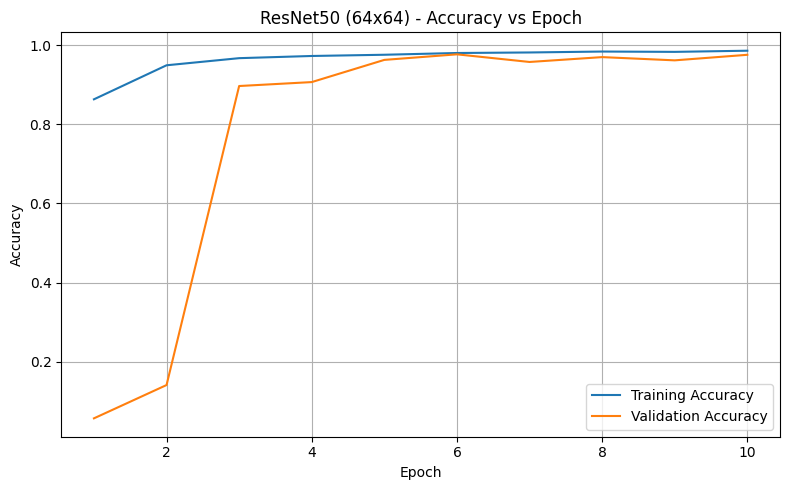

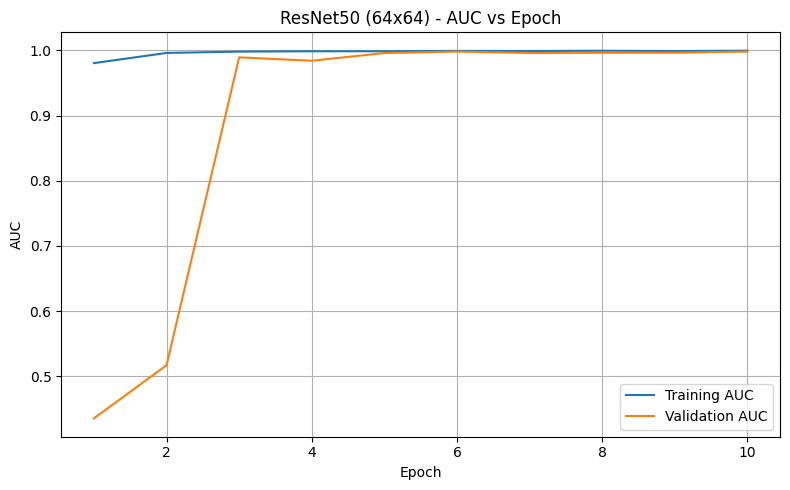

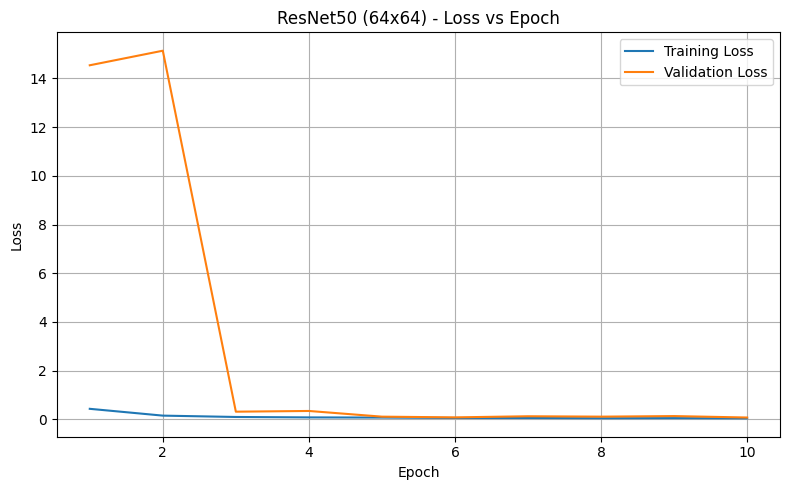

In [13]:
# 11. Plot

print("Batch Size Comparison: ResNet50 (64x64), batch size 32, with attention layer, dropout rate 0.3")

epochs = range(1, len(history_50_64_32.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64_32.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_64_32.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (64x64) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_64.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64_32.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_64_32.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (64x64) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_64.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_64_32.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_64_32.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (64x64) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_64.png")
plt.show()

In [14]:
## GradCam (batch size 16, original code, dropout rate 0.3)

import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image 

# 1) model details
model = model_50_64  
img_size = (64, 64)  
preprocess_input = lambda x: x / 255.0  

# 2) find last conv layer name 
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 70,706,074 (269.72 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,101,970 (179.68 MB)

In [15]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [16]:
# 3) prepare image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image.open(cam_path))

In [ ]:
# path: /shared/home/tzj255/bmi707_fp/image/pixel/image.jpg

# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

!ls ./image/64

In [ ]:
# 6) RUN Grad-CAM on image

Predicted class: 0


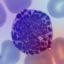

In [21]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/basophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


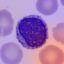

In [22]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/lymphocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 1


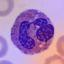

In [23]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/eosinophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


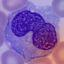

In [24]:
img_path = "/shared/home/tzj255/bmi707_fp/image/64/monocyte_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 2


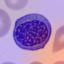

In [25]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/erythroblast_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


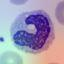

In [26]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/neutrophil_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


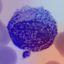

In [27]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/immature_granulocytes_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


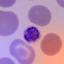

In [28]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/64/platelet_test_64.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)